In [24]:
%load_ext autoreload 
%autoreload 2
import base64
import collections
import copy
import glob
import json
import math
import os
import pickle
import random
import re
import sys

import cv2
import folium
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image, ImageDraw
from scipy import ndimage
from scipy.ndimage.interpolation import rotate
from skimage.filters import gaussian
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from tqdm import tqdm_notebook as tqdm

import pytorch_lightning as pl
# model
from efficientnet_pytorch import EfficientNet
from IPython.display import Image as showImage

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [26]:
label = train_data.loc[0, "label"]
pixel = train_data.iloc[0, 1:]

In [27]:
image = np.array(pixel).reshape(28,28)

In [37]:
# make train + val dataset

class SimpleDataset(Dataset):
    def __init__(self, phase, transforms):
        data = pd.read_csv(f"../data/{phase}.csv")
        self.phase = phase
        self.data = data
        self.transforms = transforms
    
    def __getitem__(self, index):
        if self.phase == "train":
            image = np.array(self.data.iloc[index,1:]).reshape(28,28)
            label = self.data.loc[index, "label"]
        else:
            image = np.array(self.data.iloc[index,:]).reshape(28,28)
        image = (image+0.01)/255
        
        if self.transforms:
            image = self.transforms(image)
            
        image = image.float()
        
        if self.phase == "train":
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.data)

In [38]:
train_val_dataset = SimpleDataset(
    phase = "train",
    transforms = transforms.Compose([
        transforms.ToTensor()
    ])
)
test_dataset = SimpleDataset(
    phase = "test",
    transforms = transforms.Compose([
        transforms.ToTensor(),
    ])
)

In [39]:
train_dataset, val_dataset = random_split(
    train_val_dataset, 
    [33600, 8400]
)

8 5


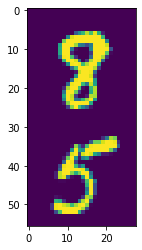

3 2


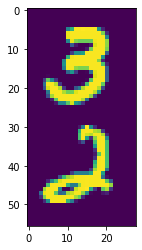

9 7


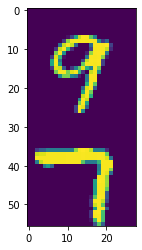

0 5


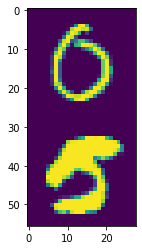

4 4


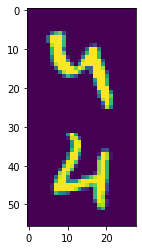

8 6


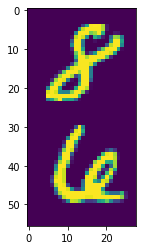

5 1


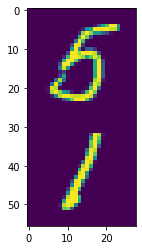

2 4


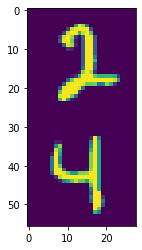

4 6


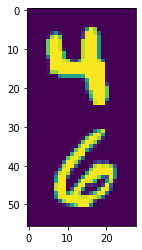

4 9


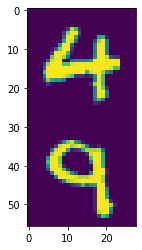

In [40]:
for i in range(10):
    image, label = train_dataset[i]
    val_image, val_l = val_dataset[i]
    print(label, val_l)
    plt.imshow(torch.cat([image[0], val_image[0]]))
    plt.show()

In [41]:
class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
#         self.model = EfficientNet.from_name('efficientnet-b3', in_channels=1,num_classes = 10)
#         self.sigmoid = nn.Softmax(dim=1)

        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False, num_classes = 10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.sigmoid = nn.Sigmoid()
        # GPUを登録
        self.register_buffer("sigma", torch.eye(3))
        
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        y = self.sigmoid(self.model(x))
        return y

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        image, label = batch

        predict = self.sigmoid(self.model(image))
        loss = F.cross_entropy(predict, label)
        self.log('train_loss', loss)
        
        _, y_hat = torch.max(predict, dim=1)
        train_acc = accuracy_score(y_hat.cpu(), label.cpu())
        self.log("train_acc", train_acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, label = batch

        predict = self.sigmoid(self.model(image))
        # loss
        loss = F.cross_entropy(predict, label)
        self.log('val_loss', loss, prog_bar=True)
        # acc
#         print(predict[0])
        _, y_hat = torch.max(predict, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), label.cpu())
#         val_acc = torch.tensor(val_acc)
        self.log("val_acc", val_acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        image = batch
        
        predict = self.sigmoid(self.model(image))
        return predict

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [42]:
# gpu_num = 8
# model = Classifier()
# trainer = pl.Trainer(gpus=gpu_num, distributed_backend="dp", 
# #                      precision=16,
#                     max_epochs=30)

# trainer.fit(model,
#             DataLoader(
#                 train_dataset,
#                 num_workers = gpu_num*2, 
#                 batch_size = 256*gpu_num, 
#                 pin_memory = True,
#                 shuffle = True
#             ), 
#             DataLoader(
#                 val_dataset,
#                 num_workers= gpu_num*2, 
#                 batch_size = 256*gpu_num,
#                 pin_memory = True
#             ))

In [43]:
gpu_num = 8
model = Classifier()
trainer = pl.Trainer(gpus=gpu_num, distributed_backend="dp", 
                     precision=16,
                    max_epochs=30)

trainer.fit(model,
            DataLoader(
                train_dataset,
                num_workers = gpu_num*2, 
                batch_size = 512*gpu_num, 
                pin_memory = True,
                shuffle = True
            ), 
            DataLoader(
                val_dataset,
                num_workers= gpu_num*2, 
                batch_size = 512*gpu_num,
                pin_memory = True
            ))

Using cache found in /home/kato/.cache/torch/hub/pytorch_vision_v0.6.0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Using native 16bit precision.

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | sigmoid | Sigmoid | 0     


1

In [54]:
test_dataloader = DataLoader(
                test_dataset,
                num_workers= gpu_num*2, 
                batch_size = 512*gpu_num,
                pin_memory = True,
                shuffle = False
            )

In [73]:
model.eval()
device = "cuda"

results = []
for images in test_dataloader:
    images = images.to(device)
    outputs = model(images)
    
    _, predicts = torch.max(outputs, dim=1)
    predicts = predicts.data.cpu().numpy()
    
    for i, predict in enumerate(predicts):
        results.append(predict)

In [75]:
submit = pd.read_csv("../data/sample_submission.csv")

for i, r in enumerate(results):
    submit.loc[i, "Label"] = r

In [85]:
index = 0
submit.to_csv(f"./submit/index_{index:03}.csv", index = False)

In [86]:
a = pd.read_csv("./submit/index_000.csv")

In [88]:
submit = pd.read_csv("../data/sample_submission.csv")